In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates
import matplotlib.cm as cm

from sklearn.cluster import KMeans

In [2]:
# define x-time-series tick formats
tickfmt = mdates.DateFormatter('%H:%M')
tickloc = mdates.HourLocator(interval = 3)

In [3]:
# import data
df = pd.read_csv("~/git/lacolombe-nowifi/etl/test.csv").query("id != 'id'")
df[['availableBikes', 'totalDocks']] = df[['availableBikes', 'totalDocks']].astype('float')
df['lastCommunicationTime'] = pd.to_datetime(df['lastCommunicationTime'])

In [4]:
# clean-up data for analysis and create master dataset
template = df.groupby(['id', 'lastCommunicationTime'])[['availableBikes', 'totalDocks']]\
  .agg(['size', 'min', 'max'])\
  .unstack(0)\
  .sort_index()\
  .ffill()

count_summary = template[('availableBikes', 'size')].notna().sum(axis = 1)
start_time = count_summary[count_summary==count_summary.max()].index.min()
master = template.loc[start_time:, template.columns.get_level_values(1).isin(['min', 'max'])]

In [part 1](https://ncho-sqd.github.io/2018/10/28/analyze_divvy_rss_feed_part1.html), we looked at some basic stats for Divvy stations and how the bike counts change over time on **Monday, October 8th, 2018**.

Most notable pattern was a **huge decrease and a sharp spike** in number of bikes parked during commute time (4:00-9:00pm).  A weaker yet interesting pattern was a **pesistent decrease** in bikes parked from morning time leading up to 12:00pm.

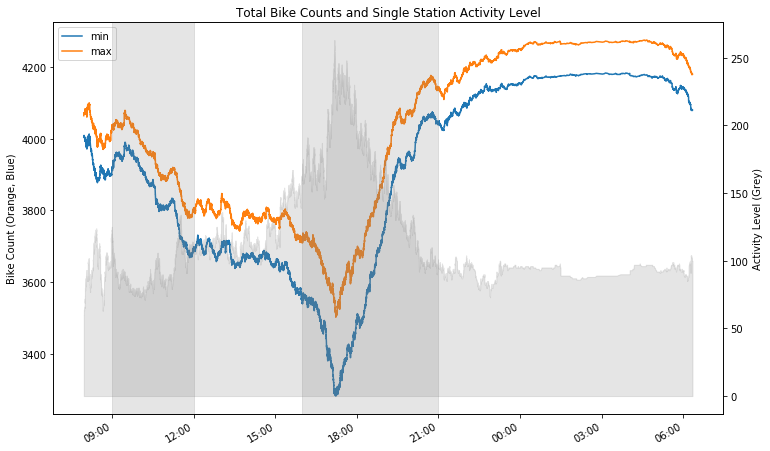

In [5]:
# activity chart
summary_bikes = master.groupby(level = [0,1], axis = 1).sum()['availableBikes']
ax = summary_bikes.plot(title = "Total Bike Counts and Single Station Activity Level", figsize = (12,8))
ax2 = ax.twinx()
ax2.fill_between(summary_bikes.index
                 , 0
                 , summary_bikes['max'] - summary_bikes['min']
                 , color = 'grey'
                 , alpha = 0.2)

# format axes labels
ax.set_xlabel('')
ax.set_ylabel("Bike Count (Orange, Blue)")
ax2.set_ylabel("Activity Level (Grey)")

# format x-axis
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# shade relevant time period
_ = plt.axvspan(pd.Timestamp("2018-10-08 09:00"), pd.Timestamp("2018-10-08 12:00"), color = 'grey', alpha = 0.2)
_ = plt.axvspan(pd.Timestamp("2018-10-08 16:00"), pd.Timestamp("2018-10-08 21:00"), color = 'grey', alpha = 0.2)

Our (yet unexamined) hypothesis for these patterns were as below:
* **Hypothesis 1: Decrease in bike count from morning until 12:00pm is driven by high usage patterns in eastern downtown Chicago stations.**
* **Hypothesis 2: Dip and spike in bike count starting from 4:00pm are caused by commuters going home from downtown Chicago to north and northwest neighborhoods.**<br/><br/>

Here, we will attempt to prove these claims by diving into the more granular patterns in individual bike stations.

<br/>
## Bike count pattern over time by station

In order to understand patterns on individual station-level, let's start by looking at **bike counts for all of the 588 stations over time**.

Each line shows a single station.  Redder lines indicate larger stations and bluer lines smaller stations.  Orange somewhere in between.

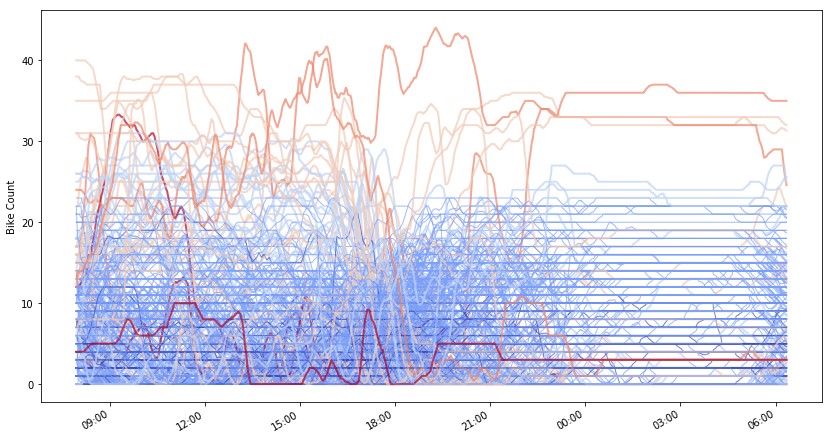

In [6]:
# create smoothed bike stock-count by each station
master_smooth = master[('availableBikes', 'min')].rolling("900s").mean()

# create color map by total dock counts
dock_cnt_unq = sorted(np.round(df['totalDocks'].astype(int), -1).unique())
colors = cm.coolwarm(np.linspace(0, 1, len(dock_cnt_unq)))
color_dict = {k: colors[i] for i, k in enumerate(dock_cnt_unq)}

# calculate momentum to identify strong implied-"flow"
temp = df[['id', 'totalDocks']].copy()
temp['totalDocks'] = np.round(temp['totalDocks'].astype(int), -1)
dock_cnt_dic = {row[0]: row[1] for row in temp[['id', 'totalDocks']].drop_duplicates().values}

# chart
for i in master_smooth.columns:
    cnt = dock_cnt_dic[i]
    lw = 2 if cnt > 20 else 1
    ax = master_smooth[i].plot(figsize = (14, 8)
                          , c = color_dict[int(cnt)]
                          , alpha = 0.7
                          , linewidth = lw)
# format axes
ax.set_xlabel('')
ax.set_ylabel("Bike Count")
ax.xaxis.set_major_locator(tickloc)
ax.xaxis.set_major_formatter(tickfmt)

plt.show()  # show chart

Too much going on here, so let's break down this chart into smaller groups of similar station size (colors).

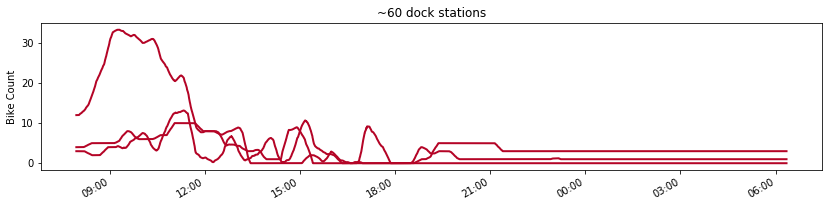

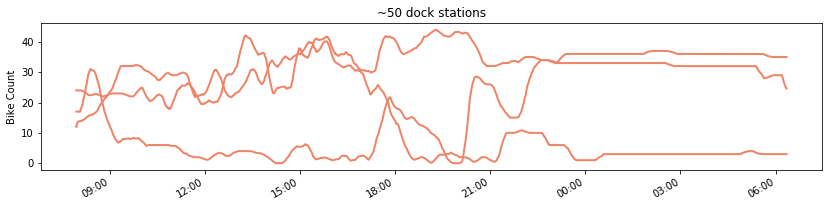

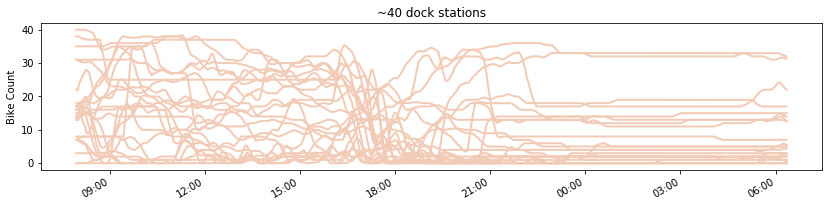

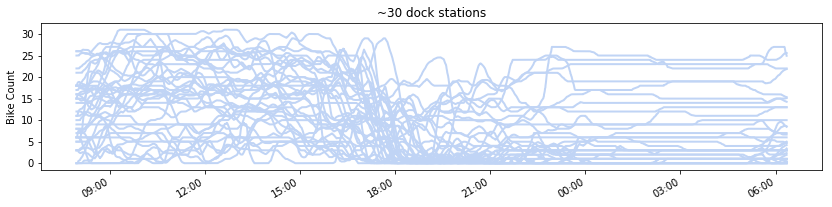

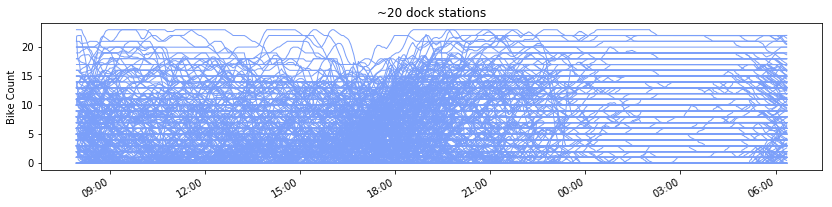

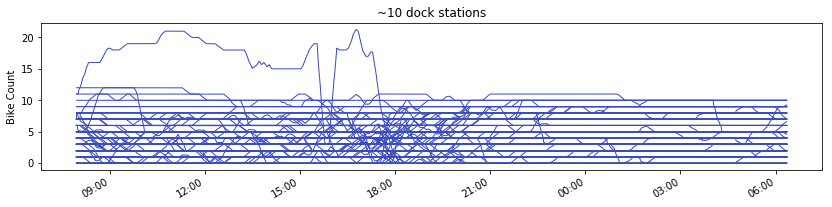

In [7]:
# chart by dock count groups
for grp in reversed(dock_cnt_unq):
    ids = [k for k, v in dock_cnt_dic.items() if v == grp]
    lw = 2 if grp > 20 else 1
    ax = master_smooth[ids].plot(figsize = (14, 3)
                            , c = color_dict[int(grp)]
                            , linewidth = lw
                            , legend = False
                            , title = "~{} dock stations".format(grp))
    # format axes
    ax.set_xlabel('')
    ax.set_ylabel("Bike Count")
    ax.xaxis.set_major_locator(tickloc)
    ax.xaxis.set_major_formatter(tickfmt)
    plt.show() # show chart

There is still a lot going on for some charts, but we start to see some patterns here.

* Huge decrease and spike in bike count during commute time is **NOT** driven by the largest stations (red line).
* Rather, you somewhat see a **decreasing** pattern for **stations around 30-40 docks** during commute time (light orange, light blue).
* You can also see a strong **increasing** pattern for **stations around 20 docks** during commute time.
* This may indicate that **bikes are moving from 30-40 dock stations to ~20 dock stations during commute time**.
<br/><br/>

We've seen that **larger stations are mostly located in the downtown Chicago area**, so the fact that bikes are moving from relatively larger to smaller stations during commute time seems to suggest that **people may indeed be using Divvy a lot to go home (surrounding neighborhoods) from their workplace (downtown Chicago area) after work**.

<br/>
## How do we know where people are going?

Ultimately, what we are trying to understand is from where to where people are moving with Divvy. The two hypothesis we laid out are essentially a claim on this **flow of people** at different times of the day.

*  This flow can be **"localized"**, meaning that people are moving from different locations to another different enough locations, which may or may not result in weak localized movement patterns throughout the Divvy system.  This kind of pattern, if any, is more difficult to find due to its sporadic and ephemeral nature.
*  The flow can also be **"global"** in a sense that many people follow **similar travel patterns that a strong movement pattern manifests in our data**.  **Patterns noted in our hypotheses are likely an expression of such "global" flows which we are trying to find evidence of**.
<br/><br/>

Let's start out by looking at **system-wide bike flows in Divvy** first.  Below chart shows "net flow" of bikes throughout Divvy, which is basically the difference in bike counts for each timestamp from the previous one. Negative values mean people docked out more bikes than docked in and vice versa for positive values.

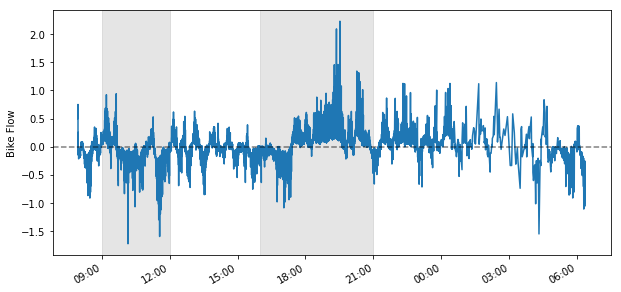

In [8]:
# sum of all stock-level delta "smoothed"
ax = master_smooth.sum(axis = 1).diff().plot(figsize = (10,5))

# format axes
ax.set_xlabel('')
ax.set_ylabel("Bike Flow")
ax.xaxis.set_major_locator(tickloc)
ax.xaxis.set_major_formatter(tickfmt)

# chart reference line/areas
_ = plt.axhline(0, c = 'black', linestyle = '--', alpha = 0.5)
_ = plt.axvspan(pd.Timestamp("2018-10-08 09:00"), pd.Timestamp("2018-10-08 12:00"), color = 'grey', alpha = 0.2)
_ = plt.axvspan(pd.Timestamp("2018-10-08 16:00"), pd.Timestamp("2018-10-08 21:00"), color = 'grey', alpha = 0.2)

Time intervals relevant to our two hypothesis are shaded grey above. We see an overall negative net flow in the earlier period and a negative net flow followed by a strong positive net flow in the later shaded period.

Now, this is an aggregated overall trend we see in the Divvy system.  What if we can decompose **component patterns**, if any, which results in the overall pattern shown above when aggregated?  If we can identify these **"building blocks"** of the overall flow pattern, wouldn't we be able to explain **"component pattern #1 + #2 = overall grey shaded area pattern"**?  We can then trace back stations driving component pattern #1 and #2 and make observations on how they are contributing to the overall pattern.

**It's much like un-building a completed lego to understand the building blocks so that you know exactly how to put them back.**

<br/>
## Developing the building blocks to understand net bike flow

I use a statistical technique called [clustering](https://en.wikipedia.org/wiki/Cluster_analysis) to identify the building blocks of overall net bike flow in Divvy.

In order to identify these building blocks more reliably, I divide the overall bike flow pattern above into consecutive 15-minute intervals and try to identify 10 component patterns in each 15-minute timeframe.  Stations with similar net flow pattern will be grouped together and rolled up to 1 distinct component pattern for each 15-minute interval. All of 588 stations will always belong to one of the 10 component patterns in each 15-minute interval.

If we understand which of the 10 component pattern groups each of the 588 stations belong to for a given 15-minute interval, we can then identify the stations that can explain the overall pattern we see.

Below is a chart showing component patterns based on the station building blocks identified in 15 minute intervals. **You see a good separation of varying degress of positive and negative component patterns identified, when added altogether  will result in overall pattern above.**  Each component pattern for a given 15 minute interval include different sets of stations with similar net flow patterns.

In [9]:
# K-means clustering to group similar station-level patterns for give time interval blocks
k = 10
kmeans = KMeans(n_clusters=k, random_state=0)
collect = []
groups = {}

for i, (_, d) in enumerate(master_smooth.groupby(pd.Grouper(freq='15Min', base=30, label='right'))):
    orig = d.copy()
    d = d.ffill().fillna(1)
    d = d + 1
    d = d / d.iloc[0]  # normalize stock-level from 0-1 range
    ts_array = np.array([d.iloc[:,i].values for i in range(d.shape[1])])
    labels = kmeans.fit(ts_array).labels_
    
    agg = orig.groupby(labels, axis = 1).sum()
    
    diff_mean = agg.diff().mean()
    rank_cols = (diff_mean.rank() - 1).values
    
    lab_replace = {old: new for new, old in zip(rank_cols, range(10))}
    labels = [lab_replace[i] for i in labels]
    
    groups[_] = list(zip(d.columns, labels))  # associate label with station id

    agg.columns = rank_cols + i * k
    collect.append(agg)
    
clustered = pd.concat(collect)

# create cluster map
cluster_map = pd.DataFrame([[k, c[0], c[1]] for k, v in groups.items() for c in v]
             , columns = ['tslot', 'id', 'group'])

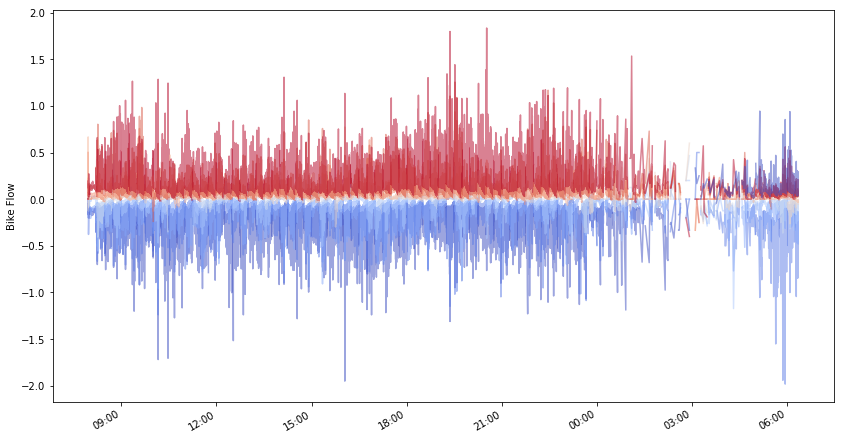

In [10]:
# group by identified cluster and chart diff in bike stock-level
clustered_diff = clustered.diff()
colors2 = cm.coolwarm(np.linspace(0, 1, k))
ax = clustered_diff.plot(figsize = (14, 8), color = colors2, alpha = 0.5, legend = False)

# format axes
ax.set_xlabel('')
ax.set_ylabel("Bike Flow")
ax.xaxis.set_major_locator(tickloc)
ax.xaxis.set_major_formatter(tickfmt)

Let's try to see each of the 10 component patterns separately.

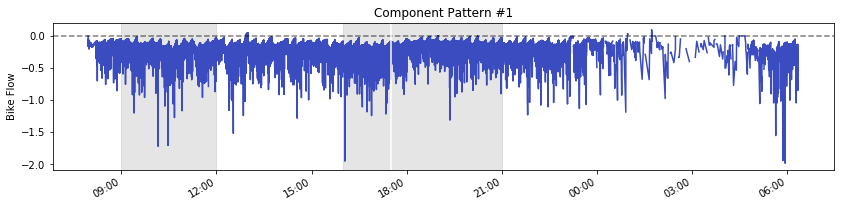

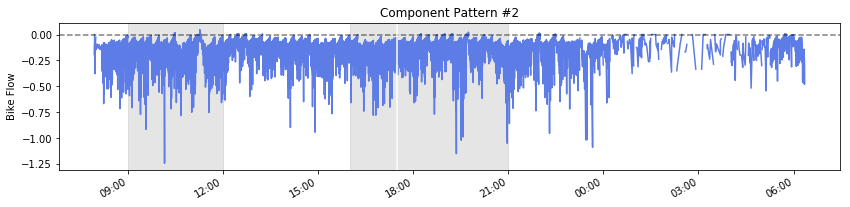

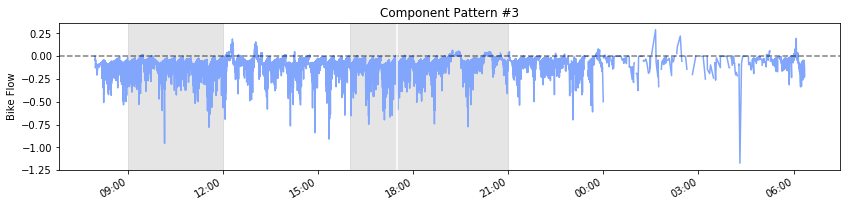

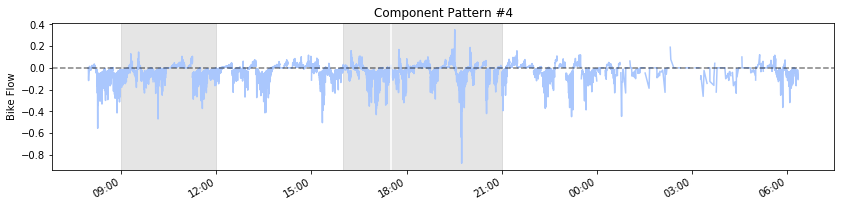

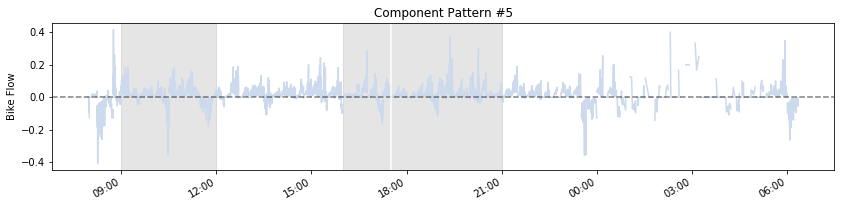

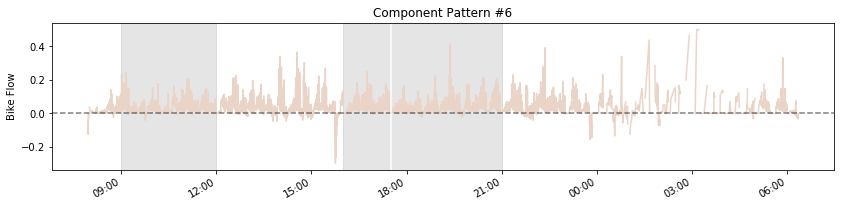

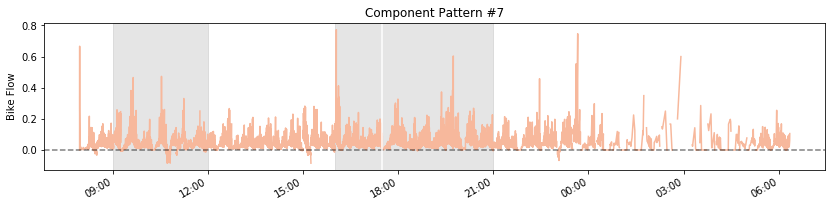

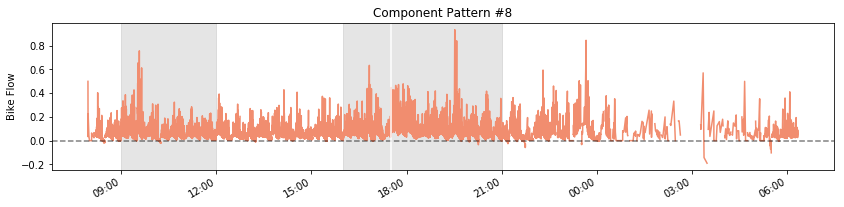

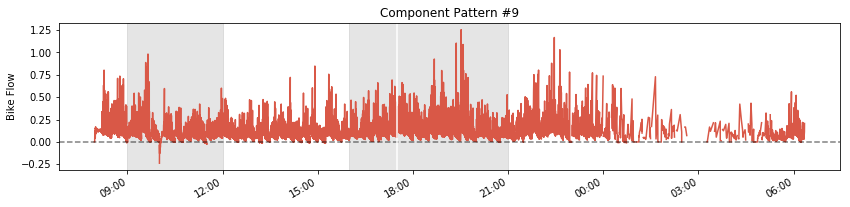

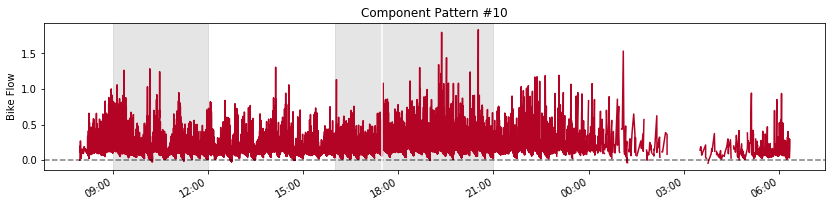

In [11]:
# show by cluster for clearer pattern
for g in range(k):
    col_select = [(i % k) == g for i in clustered_diff.columns]
    ax = clustered_diff.loc[:, col_select].plot(c = list(colors2[g])
                                           , legend = False
                                           , figsize = (14, 3))
    ax.set_title("Component Pattern #{}".format(g + 1))
    
    # format axes
    ax.set_xlabel('')
    ax.set_ylabel("Bike Flow")
    ax.xaxis.set_major_locator(tickloc)
    ax.xaxis.set_major_formatter(tickfmt)
    
    # chart reference line/area
    plt.axhline(0, c = 'black', linestyle = '--', alpha = 0.5)
    plt.axvspan(pd.Timestamp("2018-10-08 09:00"), pd.Timestamp("2018-10-08 12:00"), color = 'grey', alpha = 0.2)
    plt.axvspan(pd.Timestamp("2018-10-08 16:00"), pd.Timestamp("2018-10-08 21:00"), color = 'grey', alpha = 0.2)
    plt.axvline(pd.Timestamp("2018-10-08 17:30"), c = 'white')
    plt.show()

Separation of component patterns become more clear when looked independently.  Grey-shaded areas are time intervals relevant to our two hypotheses, with the later period further broken down into negative and positive net flow periods. This results in a total of 3 time intervals to examine.

You can see that the redder component patterns contribute to positive net flow and the bluer component to the opposite.  These two component patterns together build up to the overall net flow pattern, and underlying each component pattern are varying sets of stations in 15 minute intervals.

<br/>
## Zooming into specific timeframes

We will now zoom into the three shaded time intervals in the chart above and start getting into the weeds of identifying which stations are driving the redder or bluer component patterns.

**Stations driving redder patterns will be stations where bikes are docking into.  Stations driving bluer patterns will be stations being docked out of.**  These stations in combination can explain the overall bike flows and means that **there is a flow of people moving from bluer to redder pattern stations**.

In [34]:
# function to create template for time-slice analysis
def new_fig_template(figsize = (15,8)):
    fig, ax = plt.subplots(figsize = figsize)
    ax1 = plt.subplot2grid((2, 3), (0, 0))
    ax2 = plt.subplot2grid((2, 3), (0, 1))
    ax3 = plt.subplot2grid((2, 3), (1, 0))
    ax4 = plt.subplot2grid((2, 3), (1, 1))
    ax5 = plt.subplot2grid((2, 3), (0, 2), rowspan = 2)
    return((ax1, ax2, ax3, ax4, ax5))

# create long-lat summaries to use in map plot
summary_station = df.groupby(['id', 'stationName'])[['totalDocks', 'longitude', 'latitude']].max().astype(float)
map_coord = summary_station.agg([min, max])
id_idx = summary_station.index.get_level_values(0)

# charting function to generate time-slice deep-dive
def generate_tslice_summary_plt(start_dt, end_dt, cluster_lb, cluster_ub):
    # visulize diff trends and their decomposition
    sel_row = (cluster_map['tslot'] >= pd.Timestamp(start_dt))\
            & (cluster_map['tslot'] <= pd.Timestamp(end_dt))
    
    shade0_summary = cluster_map.loc[sel_row].groupby('id')['group'].mean()

    sel_stn_l = shade0_summary[shade0_summary <= cluster_lb].index
    sel_stn_u = shade0_summary[shade0_summary >= cluster_ub].index
    tslice_diff = master_smooth.loc[start_dt:end_dt].diff()

    ax1, ax2, ax3, ax4, ax5 = new_fig_template()
    _ = ax1.plot(tslice_diff.loc[:, sel_stn_l].sum(axis = 1), c = cm.coolwarm(10))
    _ = ax2.plot(tslice_diff.loc[:, sel_stn_u].sum(axis = 1), c = cm.coolwarm_r(10))
    _ = ax3.plot(tslice_diff.loc[:, sel_stn_l], alpha = 0.5)
    _ = ax4.plot(tslice_diff.loc[:, sel_stn_u], alpha = 0.5)
    
    # title charts
    ax1.set_title("Decrease")
    ax2.set_title("Increase")
    ax3.set_title("Decrease Sub-Component")
    ax4.set_title("Increase Sub-Component")
    
    # set axis label
    ax1.set_ylabel("Bike Flow")
    ax3.set_ylabel("Bike Flow")
    
    # format x-axis time ticks
    for ax in [ax1, ax2, ax3, ax4]:
        tickfmt2 = mdates.DateFormatter('%H:%M')
        tickloc2 = mdates.MinuteLocator(byminute=[0,30], interval = 1)
        ax.xaxis.set_major_locator(tickloc2)
        ax.xaxis.set_major_formatter(tickfmt2)

    # draw map
    m = Basemap(llcrnrlon=map_coord.loc['min', 'longitude']
                ,llcrnrlat=map_coord.loc['min', 'latitude']
                ,urcrnrlon=map_coord.loc['max', 'longitude']
                ,urcrnrlat=map_coord.loc['max', 'latitude']
                , ax = ax5
                , fix_aspect = False)

    _ = m.drawmapboundary(zorder=0) #fill_color='#9fdbff'
    _ = m.drawcounties(facecolor = 'lightgrey')

    for i, ul in enumerate([sel_stn_l, sel_stn_u]):
        size, x, y = summary_station.loc[[i in ul for i in id_idx]].values.T
        cmap = cm.coolwarm_r(10) if i else cm.coolwarm(10)
        _ = m.scatter(x,y,s=[s * 2 for s in size],edgecolors='face',marker='H',vmax=5,vmin=0,zorder=1.5
                      ,c = cmap, alpha = 0.5)

Below is a chart that shows different levels of component patterns and the stations driving them during **9:00-12:00pm, time period relevant to hypothesis #1**.

The "Decrease" chart sums up all the bluer (negative net flow) component patterns, with further sub-component broken down into different colors in the "Decrease Sub-Component" chart.  The "Increase" chart does that same for redder (positive net flow) component patterns.

The map shows where the bluer and redder component pattern stations are located for this time period.

**We can see a flow of bikes moving from east to west of downtown Chicago, as bikes should be moving from negative net flow areas (blue) to positive net flow area (red).**

Not sure why people use more bikes in east of downtown Chicago during this time, but it might be the tourists.  I think we've just proven hypothesis #1 though.

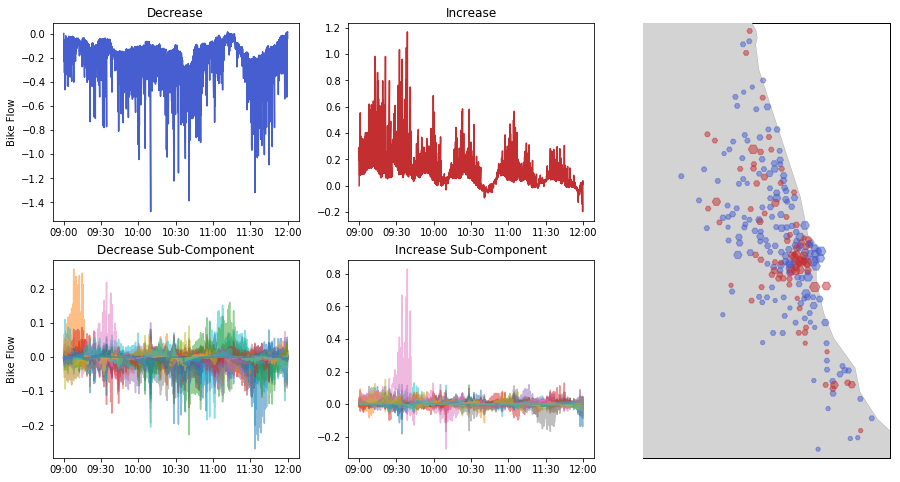

In [35]:
# call and chart summary for provided tslice
generate_tslice_summary_plt("2018-10-08 09:00:00", "2018-10-08 12:00:00", 4, 5)

<br/>
Moving onto the first part of the hypothesis #2 time interval (negative net flow), we see the same set of charts for **4:00-5:30pm** below.

**At this time, we can see bikes moving from the wider downtown area to the surrounding neighborhoods, more into north and northwestern neighborhoods.**

This seems like the early wave of commuters going back home to neighborhoods that are concentrated along the north and northwestern axes.

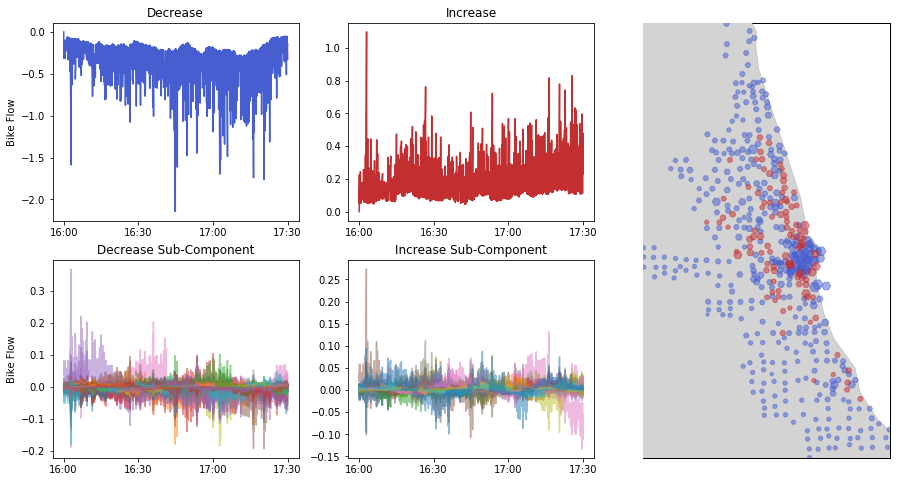

In [36]:
# call and chart summary for provided tslice
generate_tslice_summary_plt("2018-10-08 16:00:00", "2018-10-08 17:30:00", 4, 5)

<br/>
Let's move on to the last time interval of interest which is the positive net flow period of hypothesis #2, **5:30-9:00pm**.

Here, we see **continuous downtown to surrounding neighborhood movement pattern, but with slower negative flow from downtown and to more stations in the surrounding neighborhoods as can be seen from a wider areas colored in red**.

Seems like people are continuing their way home en masse, which seems to be heavily concentrated in the north and northwestern areas surrounding downtown Chicago.

I think we've proven hypothesis #2 here. Q.E.D.

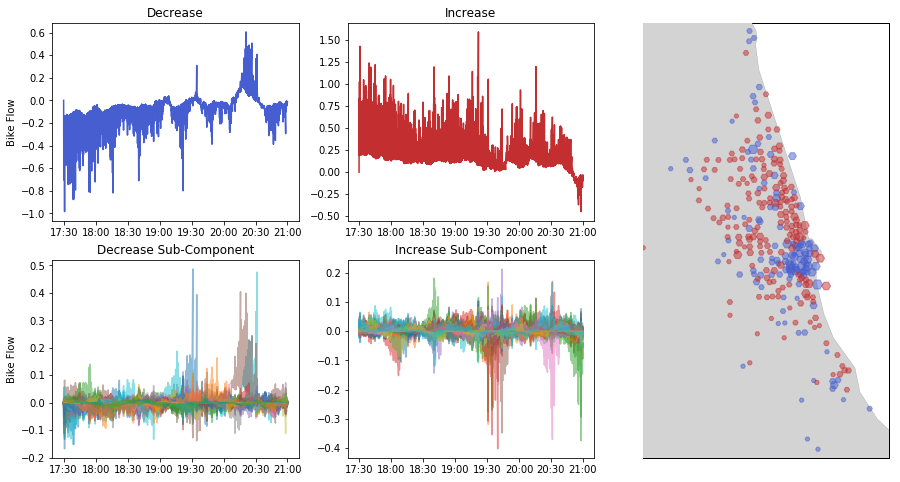

In [37]:
# call and chart summary for provided tslice
generate_tslice_summary_plt("2018-10-08 17:30:00", "2018-10-08 21:00:00", 4, 5)

<br/>
Maybe some of the observations above were obvious, but it surely was interesting for me to verify.

Moreover, I was able to develop a process in which I can de-compose an overall bike flow pattern into smaller bits and attribute them to individual stations.  This means that **this process could be used to potentially reveal more interesting "localized" patterns for those curious-minded**.

I'll drop it here though :)  Thanks a lot for reading!

<br/>
## More

Python script to download json feed from Divvy, click [here](https://github.com/lacolombe-nowifi/etl/blob/dev/scrape_divvy_rss_feed.py).

Jupyter notebook for analysis in this post, click [here](https://github.com/ncho-sqd/ncho-sqd.github.io/blob/master/original_posts/analyze_divvy_rss_feed_part2.ipynb).